Number of bins: 2
Unused capacity: 0
Runtime: 0.20453238487243652 seconds


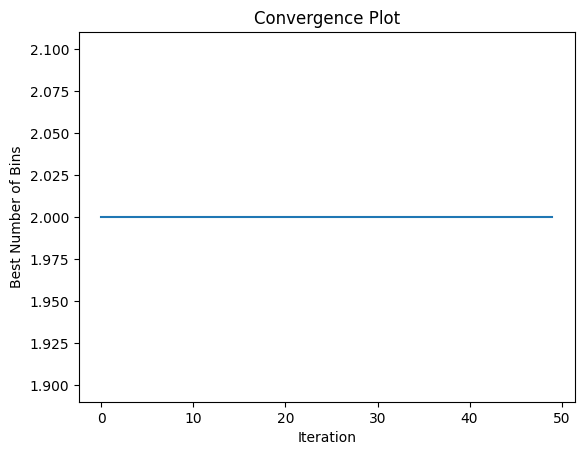

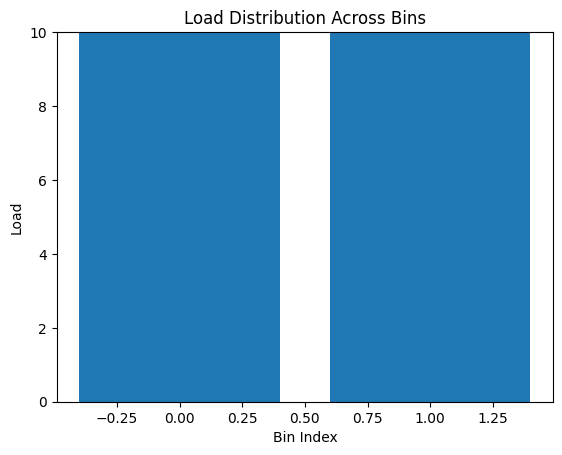

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

class ACOBinPacking:
    def __init__(self, item_sizes, capacity, num_ants=10, max_iter=50, alpha=1.0, beta=2.0, rho=0.1, Q=1.0):
        self.item_sizes = np.array(item_sizes)
        self.n = len(item_sizes)
        self.C = capacity
        self.num_ants = num_ants
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q

        # Sort items in decreasing order (like FFD)
        self.sorted_indices = np.argsort(-self.item_sizes)
        self.item_sizes = self.item_sizes[self.sorted_indices]

        # Pheromone matrix (symmetric)
        self.tau = np.ones((self.n, self.n)) * 0.1

        # Best solution tracking
        self.best_num_bins = self.n  # Worst case
        self.best_unused = float('inf')
        self.best_packing = None
        self.convergence = []

    def construct_solution(self):
        bins = []  # List of lists: each sublist is item indices in that bin
        bin_loads = []
        for i in range(self.n):
            probs = []
            candidates = []
            # Existing bins
            for j in range(len(bins)):
                remaining = self.C - bin_loads[j]
                if remaining >= self.item_sizes[i]:
                    # Average pheromone with items in bin
                    tau_avg = np.mean([self.tau[i, k] for k in bins[j]]) if bins[j] else 0.1
                    # Heuristic: prefer tight fit (small remaining after placement)
                    after_remaining = remaining - self.item_sizes[i]
                    eta = 1 / (after_remaining + 1)  # Higher if tighter
                    attr = (tau_avg ** self.alpha) * (eta ** self.beta)
                    probs.append(attr)
                    candidates.append(j)

            # Option to open new bin
            tau_new = 0.01  # Low to discourage
            eta_new = 0.01  # Low to discourage
            attr_new = (tau_new ** self.alpha) * (eta_new ** self.beta)
            probs.append(attr_new)
            candidates.append(-1)

            # If no existing bin can fit, force new bin
            if not candidates[:-1]:
                selected = -1
            else:
                # Normalize probabilities
                total = sum(probs)
                if total == 0:
                    probs = [1.0 / len(probs)] * len(probs)
                else:
                    probs = [p / total for p in probs]
                # Roulette wheel selection
                choice = np.random.choice(range(len(probs)), p=probs)
                selected = candidates[choice]

            if selected == -1:
                # Open new bin
                bins.append([i])
                bin_loads.append(self.item_sizes[i])
            else:
                # Add to existing bin
                bins[selected].append(i)
                bin_loads[selected] += self.item_sizes[i]

        return bins, bin_loads

    def run(self):
        start_time = time.time()
        for iteration in range(self.max_iter):
            ant_solutions = []
            for ant in range(self.num_ants):
                packing, loads = self.construct_solution()
                num_bins = len(packing)
                unused = sum(self.C - load for load in loads)
                ant_solutions.append((packing, num_bins, unused))

            # Sort by number of bins, then unused space
            ant_solutions.sort(key=lambda x: (x[1], x[2]))

            # Update best
            if ant_solutions[0][1] < self.best_num_bins or \
               (ant_solutions[0][1] == self.best_num_bins and ant_solutions[0][2] < self.best_unused):
                self.best_packing = ant_solutions[0][0]
                self.best_num_bins = ant_solutions[0][1]
                self.best_unused = ant_solutions[0][2]

            # Pheromone update using global best
            self.tau *= (1 - self.rho)  # Evaporation
            delta = self.Q / self.best_num_bins
            for bin_items in self.best_packing:
                for idx1 in range(len(bin_items)):
                    for idx2 in range(idx1 + 1, len(bin_items)):
                        i = bin_items[idx1]
                        k = bin_items[idx2]
                        self.tau[i, k] += delta
                        self.tau[k, i] += delta  # Keep symmetric

            self.convergence.append(self.best_num_bins)

        runtime = time.time() - start_time
        return self.best_num_bins, self.best_unused, runtime, self.convergence

    def plot_convergence(self):
        plt.plot(self.convergence)
        plt.xlabel('Iteration')
        plt.ylabel('Best Number of Bins')
        plt.title('Convergence Plot')
        plt.show()

    def plot_load_distribution(self):
        if self.best_packing is None:
            print("Run the algorithm first.")
            return
        loads = [sum(self.item_sizes[items] for items in bin) for bin in self.best_packing]
        plt.bar(range(len(loads)), loads)
        plt.ylim(0, self.C)
        plt.xlabel('Bin Index')
        plt.ylabel('Load')
        plt.title('Load Distribution Across Bins')
        plt.show()

# Example usage with a small test instance
# Sample instance: n=5, C=10, sizes=[6,5,4,3,2]
item_sizes = [6, 5, 4, 3, 2]
capacity = 10

aco = ACOBinPacking(item_sizes, capacity)
num_bins, unused, runtime, _ = aco.run()
print(f"Number of bins: {num_bins}")
print(f"Unused capacity: {unused}")
print(f"Runtime: {runtime} seconds")
aco.plot_convergence()
aco.plot_load_distribution()

# To load real benchmarks:
# Download binpack1.txt from https://people.brunel.ac.uk/~mastjjb/jeb/orlib/files/binpack1.txt
# Parse the file: first line P (number of problems)
# Then for each problem: identifier
# capacity n best_known
# then n lines of sizes
# You can write a function to read it and run for each.
# For example:
def load_binpack_file(filename, instance_idx=0):
    with open(filename, 'r') as f:
        lines = f.readlines()
    line_idx = 0
    P = int(lines[line_idx].strip())
    line_idx += 1
    for p in range(instance_idx + 1):
        identifier = lines[line_idx].strip()
        line_idx += 1
        capacity, n, best_known = map(int, lines[line_idx].strip().split())
        line_idx += 1
        sizes = []
        for _ in range(n):
            sizes.append(int(lines[line_idx].strip()))
            line_idx += 1
    return sizes, capacity, best_known

# Usage:
# sizes, C, optimal = load_binpack_file('binpack1.txt', 0)  # first instance
# aco = ACOBinPacking(sizes, C)
# etc.

# Run for at least 8 instances, record metrics, plots.
# Tune parameters if needed for better performance.
# Optional: Add local search like swap items between bins to improve.